# 1. Introduction

In recent years, computer vision has witnessed significant advancements, particularly in the field of image segmentation—the process of partitioning an image into meaningful segments to simplify its analysis. This technique is especially critical in medical imaging, where precise delineation of anatomical structures and abnormalities can greatly impact diagnosis and treatment planning.

In our project, we focus on the automated segmentation and classification of brain tumors using multimodal MRI scans. We leverage a hybrid approach that combines a deep learning segmentation model and classical machine learning for tumor type classification. Specifically, our pipeline uses a 2D U-Net architecture with a VGG19 encoder to accurately segment tumor regions in MRI images, followed by feature extraction from the segmented regions and classification using an SVM classifier.

The dataset employed in this work is the Brain Tumor Segmentation (BraTS) 2020 dataset, which provides multimodal scans—namely T1, T1CE, T2, and T2-FLAIR—along with expert-annotated segmentation masks that delineate different tumor sub-regions. By focusing on key modalities (such as T1CE and FLAIR) that offer complementary information, our approach is designed to deliver precise tumor segmentation and robust classification, ultimately aiding in improved clinical decision-making in neuro-oncology.

# 2. Download and Unzip the Dataset

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download awsaf49/brats20-dataset-training-validation
! unzip brats20-dataset-training-validation.zip


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [03:13<00:00, 24.1MB/s]
100% 4.16G/4.16G [03:13<00:00, 23.0MB/s]
Archive:  brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Not Tumor (NT) volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels.

# 4. Load and Explore the Dataset



In [3]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import preprocessing
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Gather all study directories
dataset_dir = Path(TRAIN_DATASET_PATH)
all_ids = [p.name for p in dataset_dir.iterdir() if p.is_dir()]

In [5]:
# There is a segmentation file has a naming fault we should fix it:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

try:
    os.rename(old_name, new_name)
    print("File  re-named successfully!")
except:
    print("Error | already renamed!")

File  re-named successfully!


Loading BraTS20_Training_355_flair.nii - Shape: (240, 240, 155), Dtype: float64, Min: 0.0, Max: 1854.603271484375
After scaling - Min: 0.0, Max: 1.0
Loading BraTS20_Training_355_t1.nii - Shape: (240, 240, 155), Dtype: float64, Min: 0.0, Max: 1717.368408203125
After scaling - Min: 0.0, Max: 1.0
Loading BraTS20_Training_355_t1ce.nii - Shape: (240, 240, 155), Dtype: float64, Min: 0.0, Max: 8309.0
After scaling - Min: 0.0, Max: 1.0
Loading BraTS20_Training_355_t2.nii - Shape: (240, 240, 155), Dtype: float64, Min: 0.0, Max: 5822.11474609375
After scaling - Min: 0.0, Max: 1.0
Segmentation - Shape: (240, 240, 155), Dtype: float64
Slice Number: 100


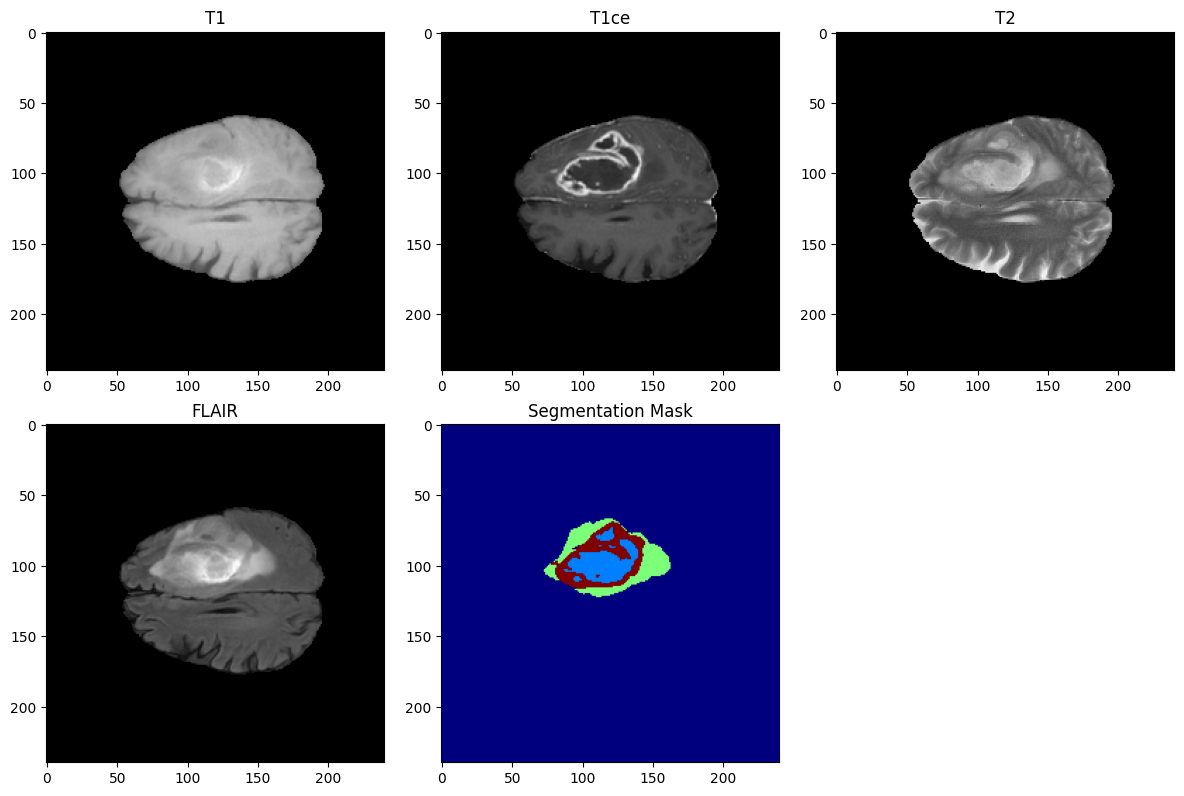

In [6]:
# Define a helper function to load and rescale a modality image
def load_and_rescale(filepath):
    img = nib.load(filepath).get_fdata()
    print(f"Loading {os.path.basename(filepath)} - Shape: {img.shape}, Dtype: {img.dtype}, Min: {img.min()}, Max: {img.max()}")
    scaler = MinMaxScaler()
    # Reshape to 2D: (num_pixels, num_slices) then back to original 3D shape
    reshaped = img.reshape(-1, img.shape[-1])
    scaled = scaler.fit_transform(reshaped).reshape(img.shape)
    print(f"After scaling - Min: {scaled.min()}, Max: {scaled.max()}")
    return scaled

# Build full paths for each modality for patient 355
base_path = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355")
flair_path = os.path.join(base_path, "BraTS20_Training_355_flair.nii")
t1_path    = os.path.join(base_path, "BraTS20_Training_355_t1.nii")
t1ce_path  = os.path.join(base_path, "BraTS20_Training_355_t1ce.nii")
t2_path    = os.path.join(base_path, "BraTS20_Training_355_t2.nii")
seg_path   = os.path.join(base_path, "BraTS20_Training_355_seg.nii")

# Load and rescale the modalities
test_image_flair = load_and_rescale(flair_path)
test_image_t1    = load_and_rescale(t1_path)
test_image_t1ce  = load_and_rescale(t1ce_path)
test_image_t2    = load_and_rescale(t2_path)

# Load the segmentation mask (do not rescale the mask)
test_image_seg = nib.load(seg_path).get_fdata()
print(f"Segmentation - Shape: {test_image_seg.shape}, Dtype: {test_image_seg.dtype}")

# Choose a slice index for visualization
slice_idx = 100
print("Slice Number:", slice_idx)

# Plot the modalities and segmentation for the selected slice
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:, :, slice_idx], cmap='gray')
plt.title('T1')

plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:, :, slice_idx], cmap='gray')
plt.title('T1ce')

plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:, :, slice_idx], cmap='gray')
plt.title('T2')

plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:, :, slice_idx], cmap='gray')
plt.title('FLAIR')

plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:, :, slice_idx], cmap='jet')
plt.title('Segmentation Mask')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/brats2/modalities.png')
plt.show()

As we observed, the maximum pixel values in our images vary, highlighting the need to rescale these values. Rescaling pixel intensities is critical because it standardizes the intensity distribution across multimodal MRI scans (T1, T1ce, T2, and T2-FLAIR) to a uniform scale. This uniformity is essential for consistent model training and analysis—it minimizes the impact of differences in acquisition protocols and scanner variations, ensuring that the model learns meaningful features for accurate tumor segmentation. Studies have shown that such normalization procedures can significantly improve segmentation performance by reducing bias introduced by raw intensity variations , .

___
Each imaging modality offers distinct insights into brain anatomy:

  - Native (T1): Reveals detailed anatomical structures and tissue composition, aiding in the identification of tumors, cysts, and other abnormalities.
  - Post-contrast T1-weighted (T1ce/T1Gd): Enhances tumor visibility using a gadolinium-based contrast agent, which accentuates abnormal vascularity and lesion boundaries.
  - T2-weighted (T2): Highlights fluid content within brain tissues, which is useful for detecting edema but can sometimes obscure lesions.
  - T2-FLAIR (Fluid Attenuated Inversion Recovery): Suppresses the high signal from fluids (e.g., cerebrospinal fluid), making lesions in the white matter more conspicuous.

For clinical experts, the comprehensive view provided by these four modalities is invaluable for precise tumor analysis and treatment planning. However, in our artificial intelligence approach, we aim to reduce computational and memory demands by streamlining the input data. Consequently, we opt to use only two modalities:

  - T1ce is chosen over native T1 because its contrast enhancement offers clearer delineation of abnormal regions.
  - T2-FLAIR is preferred over T2 as it minimizes fluid signal interference, thereby highlighting pathological changes more effectively.

This targeted modality selection not only speeds up the segmentation process but also enhances model performance by reducing extraneous information , .

Sources

  > Nyúl, L.G., Udupa, J.K., & Zhang, X. (2000). New variants of a method of MRI scale standardization. IEEE Transactions on Medical Imaging.

  > Tustison, N.J., Avants, B.B., Cook, P.A., Zheng, Y., Egan, A., Yushkevich, P.A., & Gee, J.C. (2010). N4ITK: Improved N3 bias correction. IEEE Transactions on Medical Imaging.

  > Radiopaedia articles on MRI brain imaging and modality selection.

  > American College of Radiology (ACR) guidelines on brain MRI protocols.

### Images Format

All images in our dataset are stored in the NIfTI (.nii) format, a widely adopted standard in neuroimaging. The NIfTI format is designed to efficiently handle complex, multi-dimensional data while embedding crucial metadata—such as spatial orientation and scaling—that aids in accurately interpreting 3D brain structures , .

To better understand the data structure, consider the following snippet that displays the shape of a modality scan and its corresponding segmentation mask:

In [7]:
# Modality shape
print("Modality: ", test_image_t2.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As seen from the output, both modality images and segmentation masks are three-dimensional. These dimensions represent the width, height, and depth of the scan. The depth consists of a series of 2D slices, each of which captures a cross-sectional view of the brain, and when stacked together, they form a complete 3D representation.

In medical imaging, these three dimensions correspond to the three primary anatomical planes:

  - **Axial (Transverse)** Plane: Divides the brain into upper and lower parts. An axial slice is essentially a horizontal cut through the brain.
  - **Coronal (Frontal)** Plane: Divides the brain into front (anterior) and back (posterior) sections. A coronal slice provides a vertical cut that separates the frontal and occipital regions.
  - **Sagittal (Lateral)** Plane: Divides the brain into left and right halves. A sagittal slice offers a side view of the brain.

Understanding these planes is crucial for accurately interpreting the images and effectively utilizing them in segmentation tasks, as each plane offers unique insights into anatomical structures and potential abnormalities. For further information on the NIfTI format and its applications in neuroimaging.

Slice number: 100


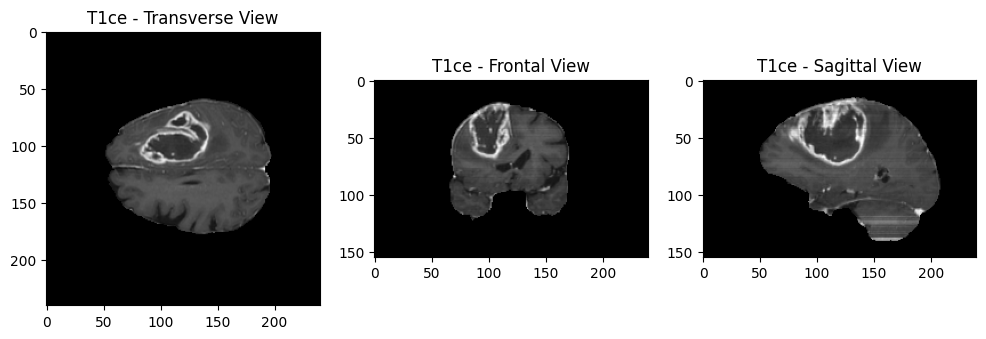

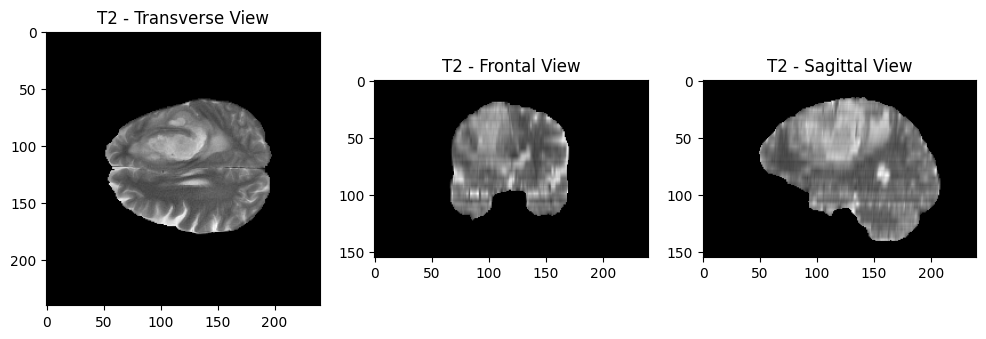

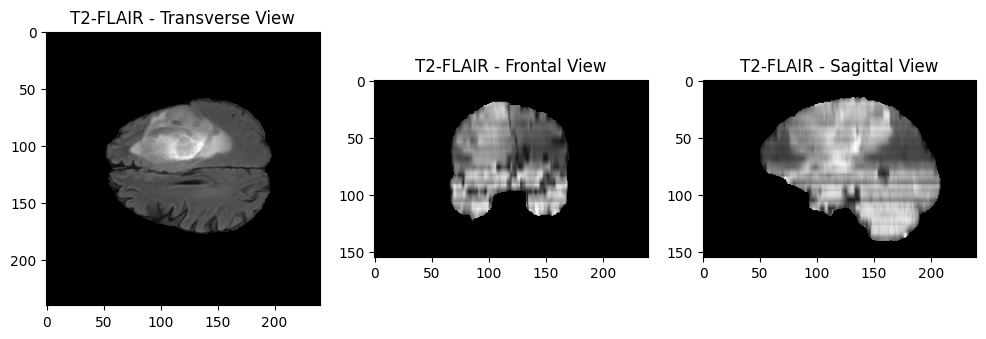

In [8]:
slice = 100
print("Slice number: " + str(slice))

# T1ce Views
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:, :, slice], cmap='gray')
plt.title('T1ce - Transverse View')
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:, slice, :], 90, resize=True), cmap='gray')
plt.title('T1ce - Frontal View')
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice, :, :], 90, resize=True), cmap='gray')
plt.title('T1ce - Sagittal View')
plt.savefig('/content/drive/MyDrive/brats2/t1ce_view.png')
plt.show()

# T2 Views
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(test_image_t2[:, :, slice], cmap='gray')
plt.title('T2 - Transverse View')
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t2[:, slice, :], 90, resize=True), cmap='gray')
plt.title('T2 - Frontal View')
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t2[slice, :, :], 90, resize=True), cmap='gray')
plt.title('T2 - Sagittal View')
plt.savefig('/content/drive/MyDrive/brats2/t2_view.png')
plt.show()

# T2-FLAIR Views
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(test_image_flair[:, :, slice], cmap='gray')
plt.title('T2-FLAIR - Transverse View')
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_flair[:, slice, :], 90, resize=True), cmap='gray')
plt.title('T2-FLAIR - Frontal View')
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_flair[slice, :, :], 90, resize=True), cmap='gray')
plt.title('T2-FLAIR - Sagittal View')
plt.savefig('/content/drive/MyDrive/brats2/t2_flair_view.png')
plt.show()




This visualization and explanation clearly illustrate how each plane offers distinct anatomical insights, ultimately enhancing our ability to perform comprehensive analysis and segmentation in brain tumor imaging.

Expert Segmentations and Their Importance

Expert-provided segmentation masks are invaluable in clinical neuroimaging because they capture detailed information about brain tumors. These annotations provide critical insights into:

  - **Location:** Pinpointing the exact anatomical region of the tumor.
  - **Size and Shape:** Measuring the tumor’s dimensions and form.
  - **Type:** Differentiating among various tumor components (e.g., necrotic core, edema, enhancing tumor).
  - **Heterogeneity:** Revealing distinct tissue characteristics within the tumor, such as areas of necrosis versus solid tissue.
  - **Surrounding Tissue Involvement:** Showing the interaction between the tumor and adjacent brain structures.
  - **Cross-Modality Comparison:** Allowing clinicians to integrate information from multiple imaging modalities for a comprehensive assessment.

Such detailed segmentations are critical for diagnosis, treatment planning, and monitoring tumor progression. They also serve as high-quality ground truth data for training and evaluating automated segmentation models. Research has demonstrated that accurate segmentation is linked to improved prognostic assessments and treatment outcomes , .

To visually interpret these segmentations, we map the categorical labels to a custom colormap. In our example, we use four distinct colors to represent:

- **Class 0 (Not Tumor):**
This class represents normal brain tissue or background, where no tumor tissue is present.

- **Class 1 (Non-Enhancing Tumor):**
This class corresponds to the necrotic or non-enhancing core regions of the tumor. These areas typically lack contrast enhancement and may include dead or less active tumor tissue.

- **Class 2 (Edema):**
This class identifies regions of peritumoral edema, which is the swelling around the tumor caused by fluid accumulation. Edema is important for understanding the extent of the tumor’s impact on surrounding brain tissue.

- **Class 4 (Enhancing Tumor):**
This class captures the actively enhancing parts of the tumor, visible after the administration of a contrast agent. These regions often indicate aggressive tumor tissue with increased blood flow and permeability.

Below is the code that plots the segmentation for a given slice using a custom colormap and normalization:

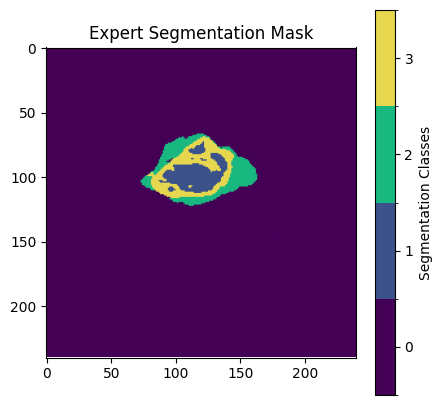

In [9]:
# Define a custom color map for segmentation labels:
# Colors are chosen to clearly differentiate the classes.
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Plot the segmentation mask for a given slice (using the previously defined 'slice' variable)
plt.figure(figsize=(5, 5))
plt.imshow(test_image_seg[:, :, slice], cmap=cmap, norm=norm)
plt.title("Expert Segmentation Mask")
plt.colorbar(ticks=[0, 1, 2, 3], label='Segmentation Classes')
plt.savefig('/content/drive/MyDrive/brats2/segmentation_mask.png')
plt.show()


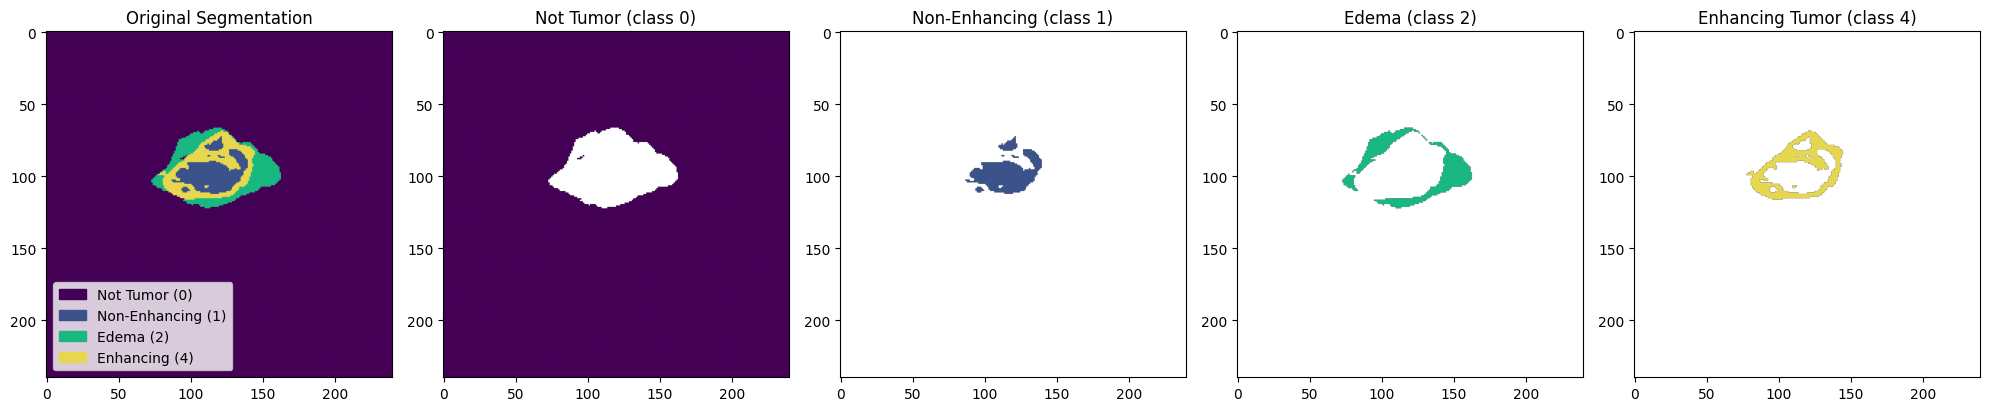

In [10]:
# Isolation of each class from the segmentation
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan  # Background / Not Tumor

seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan  # Non-Enhancing Tumor Core

seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan  # Edema

seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan  # Enhancing Tumor (Note: class 4 might be reassigned to 3 in some settings)

# Define class labels and create a legend for visualization
class_names = ['Not Tumor (0)', 'Non-Enhancing (1)', 'Edema (2)', 'Enhancing (4)']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

# Plotting the original segmentation alongside each isolated class
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

# Original segmentation
ax[0].imshow(test_image_seg[:, :, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend_handles, loc='lower left')

# Isolated Class 0: Background / Not Tumor
ax[1].imshow(seg_0[:, :, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

# Isolated Class 1: Non-Enhancing Tumor Core
ax[2].imshow(seg_1[:, :, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing (class 1)')

# Isolated Class 2: Edema
ax[3].imshow(seg_2[:, :, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

# Isolated Class 4: Enhancing Tumor
ax[4].imshow(seg_4[:, :, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/brats2/segmentation_classes.png')
plt.show()


Visualizing these isolated classes separately not only validates the quality of the expert annotations but also aids clinicians in understanding the tumor’s heterogeneity and its interaction with surrounding tissues. This comprehensive insight is vital for precise diagnosis, treatment planning, and monitoring tumor progression.

---

To summarize our data exploration:

- **Modalities:** Each sample/patient has 4 different modalities (T1, T1CE, T2, and FLAIR), accompanied by a segmentation indicating tumor areas.
- **Selected Modalities:** We will focus on T1CE and FLAIR as they provide complementary information about the brain's anatomy and tissue contrast.
- **3D Images:** Each image is 3D and can be analyzed through 3 different planes composed of 2D slices.
- **Informative Slices:** Many slices contain little or no information. We will use slices in the (50:-50) interval. You can customize this range, but note that changing it may affect training time.
- **Segmentation Classes:** Segmentation images contain 1 to 4 classes. Class 4 will be reassigned to 3 since class 3 is missing.
- **Background Class:** Class 0 (background) is over-represented. Cropping might remove important information, so we will keep the images as they are.

Now that we understand our data better, it's time to prepare for model training.

# 5. Dataset Splitting

To train and evaluate our model effectively, we need to partition our dataset into three subsets:

  - **Training Set (70%):** Used to learn the model parameters.
  - **Validation Set (approximately 20%):** Used for tuning hyperparameters and preventing overfitting.
  - **Test Set (10%):** Used for assessing the final model’s performance on unseen data.

This split can be done randomly or in a stratified manner (to preserve the class distribution), which is especially useful when dealing with imbalanced datasets. Properly splitting the dataset is crucial for building a robust model that generalizes well to new data.

Train: 258 (69.9%)
Val:   74 (20.1%)
Test:  37 (10.0%)


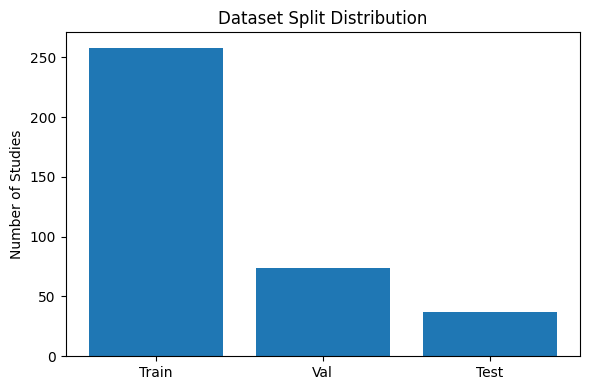

In [13]:
train_plus_val_ids, test_ids = train_test_split(
    all_ids,
    test_size=0.10,
    random_state=42
)

# 3) Split the remaining 90% into train (≈70%) and val (≈20%)
#    Note: 0.70/(0.70+0.20) ≈ 0.78 of the remaining
train_ids, val_ids = train_test_split(
    train_plus_val_ids,
    test_size=0.20 / (0.70 + 0.20),
    random_state=42
)

# 4) Quick sanity check & print
total = len(all_ids)
print(f"Train: {len(train_ids)} ({len(train_ids)/total:.1%})")
print(f"Val:   {len(val_ids)} ({len(val_ids)/total:.1%})")
print(f"Test:  {len(test_ids)} ({len(test_ids)/total:.1%})")

# 5) Save splits so you don’t re‐shuffle by accident later
import csv
for split_name, split_list in [("train", train_ids),
                               ("val",   val_ids),
                               ("test",  test_ids)]:
    with open(f"{split_name}_ids.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([split_name + "_id"])
        for sid in split_list:
            writer.writerow([sid])

# 6) Plot distribution
plt.figure(figsize=(6,4))
counts = [len(train_ids), len(val_ids), len(test_ids)]
plt.bar(["Train", "Val", "Test"], counts)
plt.ylabel("Number of Studies")
plt.title("Dataset Split Distribution")
plt.tight_layout()
plt.show()


In [21]:
# Define segmentation classes (with class 4 reassigned to 3)
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',  # or NON-ENHANCING tumor CORE
    2: 'EDEMA',
    3: 'ENHANCING'      # original 4 -> converted into 3
}

# Parameters for slice selection and image resizing
VOLUME_SLICES = 100       # Number of slices to extract from each volume
VOLUME_START_AT = 22      # Starting slice index (ignore initial slices with little info)
IMG_SIZE = 128            # Resize each slice to 128x128 pixels

 the DataGenerator class is responsible for loading and preprocessing the MRI data efficiently during training. Specifically, it:

  * Loads the T2-FLAIR and T1CE modalities.
  * Selects a specific number of 2D slices from each 3D MRI scan.
  * Resizes the images to 128×128 pixels for uniform input size.
  * Converts segmentation labels to one-hot encoded masks.
  * Normalizes the intensity values for better model performance.
  * Performes data augmentation on the fly.

In [22]:

# Data augmentation function for both image and mask
def augment_data(image, mask):
    """Apply random augmentation to the image and corresponding mask."""
    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    # Random vertical flip
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    # Random rotation: choose 0, 90, 180, or 270 degrees
    rotations = np.random.choice([0, 1, 2, 3])
    image = np.rot90(image, k=rotations)
    mask = np.rot90(mask, k=rotations)
    return image, mask

class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras from the BraTS dataset with augmentation."""
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2,
                 shuffle=True, augment=False):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment  # Flag to apply augmentation
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes for the current batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Get list of study IDs for the current batch
        Batch_ids = [self.list_IDs[k] for k in indexes]
        # Generate data for the batch
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        """Generates data containing batch_size samples.
        X: (n_samples, IMG_SIZE, IMG_SIZE, n_channels)
        y: (n_samples, 240, 240) - raw segmentation (to be one-hot encoded)
        Y: (n_samples, IMG_SIZE, IMG_SIZE, 4) - one-hot encoded segmentation
        """
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data for each study in the batch
        for c, study_id in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, study_id)

            # Load the FLAIR modality
            flair_path = os.path.join(case_path, f'{study_id}_flair.nii')
            flair = nib.load(flair_path).get_fdata()

            # Load the T1CE modality
            t1ce_path = os.path.join(case_path, f'{study_id}_t1ce.nii')
            t1ce = nib.load(t1ce_path).get_fdata()

            # Load the segmentation mask
            seg_path = os.path.join(case_path, f'{study_id}_seg.nii')
            seg = nib.load(seg_path).get_fdata()

            # For each selected slice in the volume, extract and resize images and mask
            for j in range(VOLUME_SLICES):
                idx = j + VOLUME_START_AT
                # Resize each slice to the target IMG_SIZE
                flair_slice = cv2.resize(flair[:, :, idx], (IMG_SIZE, IMG_SIZE))
                t1ce_slice = cv2.resize(t1ce[:, :, idx], (IMG_SIZE, IMG_SIZE))
                seg_slice = cv2.resize(seg[:, :, idx], (240, 240), interpolation=cv2.INTER_NEAREST)

                # Optionally apply data augmentation
                if self.augment:
                    # Stack the modalities to apply the same transform
                    combined = np.stack([flair_slice, t1ce_slice], axis=-1)
                    combined, seg_slice = augment_data(combined, seg_slice)
                    flair_slice = combined[..., 0]
                    t1ce_slice = combined[..., 1]

                # Store the data in X and y arrays
                X[j + VOLUME_SLICES * c, :, :, 0] = flair_slice
                X[j + VOLUME_SLICES * c, :, :, 1] = t1ce_slice
                y[j + VOLUME_SLICES * c] = seg_slice

        # Reassign label: convert any occurrence of label 4 to label 3
        y[y == 4] = 3
        # One-hot encode the segmentation mask (4 classes)
        mask = tf.one_hot(y, 4)
        # Resize the mask to match the input image dimensions
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return X / np.max(X), Y

# Create data generators for training, validation, and testing
# Enable augmentation in the training generator
training_generator = DataGenerator(train_ids, augment=True)
valid_generator = DataGenerator(val_ids, augment=False)
test_generator = DataGenerator(test_ids, augment=False)

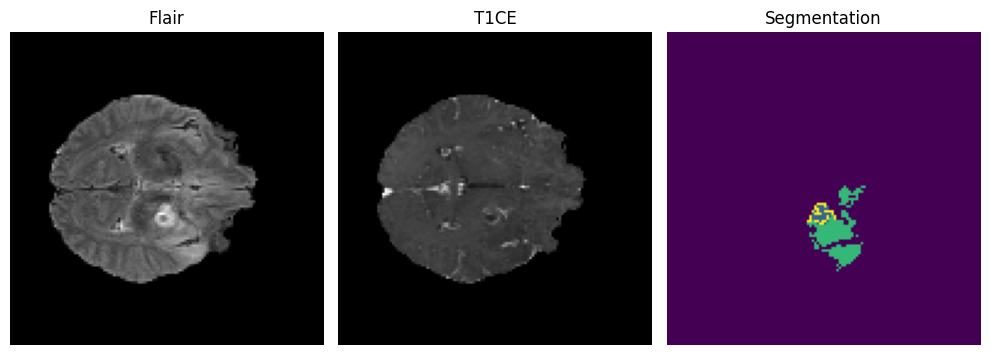

In [31]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/brats2/slice_segmentation.png')
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

slice_index = 40  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

# 7. Loss Function and Evaluation Metrics

*   List item
*   List item



### Loss Function

When training a CNN for segmentation, the loss function quantifies the difference between the predicted segmentation mask and the ground truth. For multi-class segmentation, categorical cross-entropy is widely used—it measures the discrepancy between the predicted probability distribution for each pixel and its one-hot encoded ground truth label. However, because segmentation performance depends not only on per-pixel accuracy but also on the spatial overlap between predicted and actual regions, the Dice loss is often added. Dice loss emphasizes the overlap between the predicted mask and the ground truth, thereby encouraging the model to focus on the shape and extent of the tumor.

By combining categorical cross-entropy and Dice loss, we ensure that the model learns both accurate pixel-wise classifications and meaningful region overlaps, resulting in improved segmentation performance.

In [32]:


# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss




### Per Class Dice Coefficient Functions

These functions calculate the Dice coefficient for specific tumor classes in segmentation tasks, helping to measure the model's performance in predicting different tumor regions:

- **dice_coef_necrotic:** Calculates the Dice coefficient for the necrotic (dead tissue) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the necrotic class.
  
- **dice_coef_edema:** Calculates the Dice coefficient for the edema (swelling) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the edema class.
  
- **dice_coef_enhancing:** Calculates the Dice coefficient for the enhancing tumor region. It computes the intersection over the sum of squares of the true and predicted values for the enhancing class.

In [33]:


# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



### Evaluation Metrics for Segmentation



In segmentation tasks, accuracy measures the overall proportion of correctly classified pixels. However, in datasets like BraTS2020—where the background (non-tumor) pixels vastly outnumber tumor pixels—accuracy can be misleading. Therefore, additional metrics are used:

  * **Precision:** The fraction of pixels predicted as tumor that are actually tumor. It indicates how reliable the positive predictions are.
  * **Sensitivity (Recall):** The fraction of actual tumor pixels that are correctly predicted. It reflects the model’s ability to detect tumor pixels.
  * **Specificity:** The fraction of non-tumor pixels that are correctly predicted as non-tumor. It helps evaluate how well the model avoids false positives.

These metrics provide a more comprehensive assessment of model performance, especially on imbalanced datasets.

In [34]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


# 8. Defining the Segmentation Model: U-Net


### U-Net

We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation. U-Net is particularly effective for segmenting regions of interest that are small and have complex shapes, such as tumors in MRI scans. This architecture was introduced in 2015 by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

Since the BraTS2020 dataset consists of 3D images, with each image comprising multiple 2D slices in three orthogonal planes, we have two options: using a 2D U-Net or a 3D U-Net.

- **3D U-Net:** More suitable for leveraging the 3D spatial context of the images, reducing the risk of false positives and false negatives from partial information in individual slices. However, it requires more computational resources and memory.
- **2D U-Net:** Faster and requires less memory, advantageous when working with large datasets or limited computational resources.

In practice, it’s useful to try both architectures and compare their performance. We will opt for a 2D U-Net implementation due to its efficiency and lower resource requirements.

In [35]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

## Build and Plot the Model

*   List item
*   List item



In [36]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

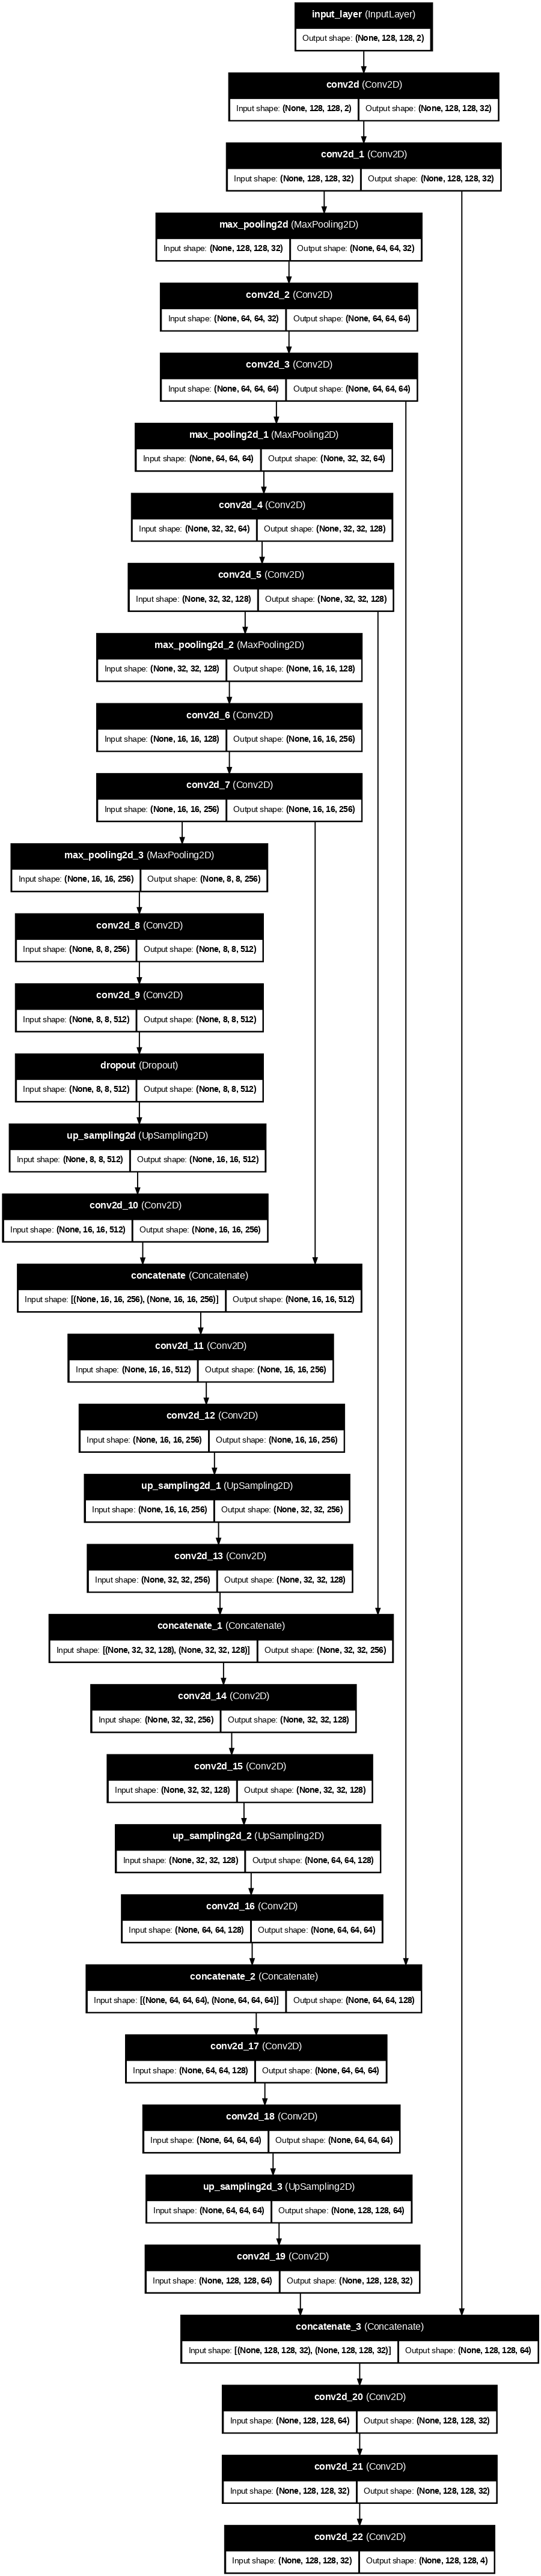

In [37]:


plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)



## Set up callbacks

In [38]:
import csv
import tensorflow as tf

class EpochCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename, separator=',', append=False):
        super(EpochCSVLogger, self).__init__()
        self.filename = filename
        self.separator = separator
        self.append = append
        self.csv_file = None
        self.writer = None
        self.header_written = False

    def on_train_begin(self, logs=None):
        mode = 'a' if self.append else 'w'
        self.csv_file = open(self.filename, mode, newline='')
        self.writer = csv.writer(self.csv_file, delimiter=self.separator)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Write header only once using keys from the first epoch's logs
        if not self.header_written:
            header = ['epoch'] + sorted(logs.keys())
            self.writer.writerow(header)
            self.header_written = True
        # Write the epoch's logs in the same order as header
        row = [epoch] + [logs.get(key) for key in sorted(logs.keys())]
        self.writer.writerow(row)
        self.csv_file.flush()

    def on_train_end(self, logs=None):
        if self.csv_file is not None:
            self.csv_file.close()



callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/brats2/best_model.weights.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    EpochCSVLogger('/content/drive/MyDrive/brats2/training.log', separator=',', append=False)
]





# 9. Train and Save the Model

We are now ready to train our deep neural network using the `.fit()` method in Keras. We will pass our three callbacks to this method to be executed during the training process, which will last for 35 epochs.

In [39]:
tf.keras.backend.clear_session()

history_obj = model.fit(training_generator,
                        epochs=45,
                        steps_per_epoch=len(train_ids),
                        callbacks=callbacks,
                        validation_data=valid_generator
                        )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9443 - dice_coef: 0.2532 - dice_coef_edema: 0.0843 - dice_coef_enhancing: 0.0304 - dice_coef_necrotic: 0.0389 - loss: 0.2063 - mean_io_u: 0.4888 - precision: 0.9418 - sensitivity: 0.9257 - specificity: 0.9895
Epoch 1: val_loss improved from inf to 0.07316, saving model to /content/drive/MyDrive/brats2/best_model.weights.h5
258/258 ━━━━━━━━━━━━━━━━━━━━ 119s 350ms/step - accuracy: 0.9444 - dice_coef: 0.2532 - dice_coef_edema: 0.0844 - dice_coef_enhancing: 0.0305 - dice_coef_necrotic: 0.0390 - loss: 0.2059 - mean_io_u: 0.4889 - precision: 0.9419 - sensitivity: 0.9259 - specificity: 0.9895 - val_accuracy: 0.9831 - val_dice_coef: 0.2693 - val_dice_coef_edema: 0.1049 - val_dice_coef_enhancing: 0.0696 - val_dice_coef_necrotic: 0.0575 - val_loss: 0.0732 - val_mean_io_u: 0.3750 - val_precision: 0.9831 - val_sensitivity: 0.9831 - val_specificity: 0.9944 - learning_rate: 0.0010
Epoch 2/45
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/ste

In [40]:
model.save("/content/drive/MyDrive/brats2/seg_model.keras")


# 10. Load the Trained Model

We will load our trained neural network model using Keras. The load_model method allows us to reload the saved model, including custom metrics and loss functions we defined during training. Here’s how we do it:


In [41]:
model = keras.models.load_model('/content/drive/MyDrive/brats2/seg_model.keras',
                                   custom_objects={
                                       "accuracy": tf.keras.metrics.MeanIoU(num_classes=4),
                                       "dice_coef": dice_coef,
                                       "precision": precision,
                                       "sensitivity": sensitivity,
                                       "specificity": specificity,
                                       "dice_coef_necrotic": dice_coef_necrotic,
                                       "dice_coef_edema": dice_coef_edema,
                                       "dice_coef_enhancing": dice_coef_enhancing
                                   },
                                   compile=False)

# 11. Metrics Analysis
Now that the training is complete, we can examine the CSVLogger callback to gain insights into the training process and our model's performance. The CSVLogger records metrics such as accuracy, loss, Dice coefficient, and Mean IoU for each epoch, allowing us to track the model’s progress over time. By analyzing this log, we can identify trends, assess the effectiveness of our training strategy, and make informed decisions for future improvements. This thorough review ensures our model is performing optimally and ready for deployment.

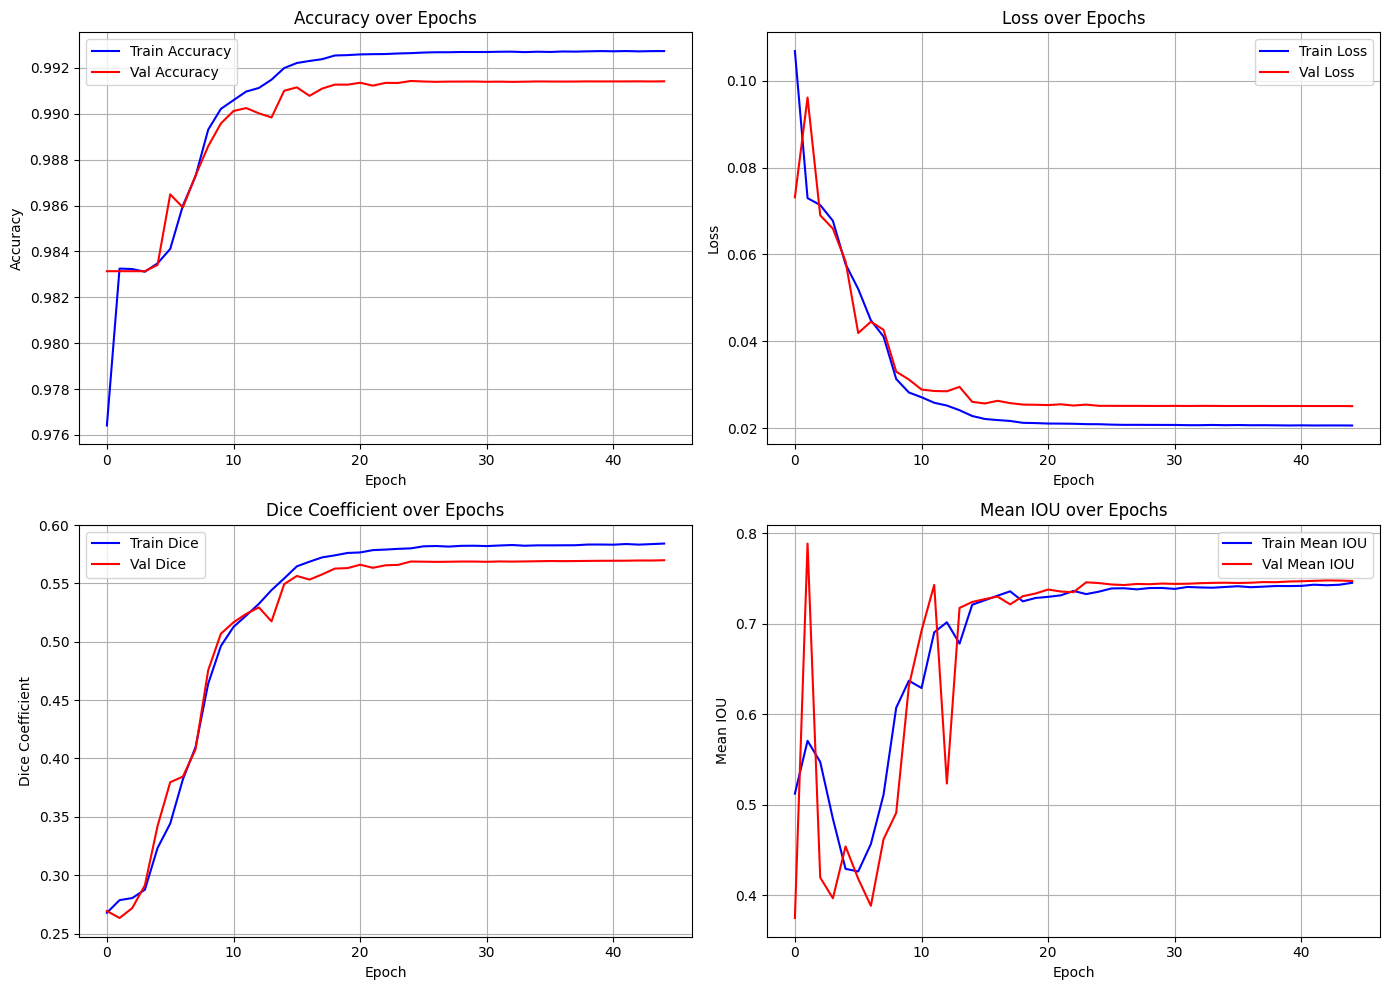

In [42]:
history = pd.read_csv('/content/drive/MyDrive/brats2/training.log', sep=',', engine='python')

# Define the number of epochs based on the logged data
epochs = range(len(history['accuracy']))

# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Accuracy
axs[0, 0].plot(epochs, history['accuracy'], 'b-', label='Train Accuracy')
axs[0, 0].plot(epochs, history['val_accuracy'], 'r-', label='Val Accuracy')
axs[0, 0].set_title('Accuracy over Epochs')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Loss
axs[0, 1].plot(epochs, history['loss'], 'b-', label='Train Loss')
axs[0, 1].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
axs[0, 1].set_title('Loss over Epochs')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Dice Coefficient
axs[1, 0].plot(epochs, history['dice_coef'], 'b-', label='Train Dice')
axs[1, 0].plot(epochs, history['val_dice_coef'], 'r-', label='Val Dice')
axs[1, 0].set_title('Dice Coefficient over Epochs')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Dice Coefficient')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Mean IOU
axs[1, 1].plot(epochs, history['mean_io_u'], 'b-', label='Train Mean IOU')
axs[1, 1].plot(epochs, history['val_mean_io_u'], 'r-', label='Val Mean IOU')
axs[1, 1].set_title('Mean IOU over Epochs')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Mean IOU')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/brats2/metrics_graphs.png')
plt.show()



The accuracy graph shows that both training and validation accuracy increase over the epochs and reach a plateau, indicating that the model is learning from the data and generalizing well without overfitting.

The loss graph demonstrates that both training and validation losses decrease over time, further confirming that the model is effectively learning from the data. Notably, the best model performance is achieved around epoch 19, as indicated in the training logs.

Finally, the Dice coefficient graph shows a steady increase in both training and validation Dice coefficients, reinforcing that the model's segmentation capabilities are improving consistently.



# 12. Predict Tumor Segmentations


In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input

IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef, precision, sensitivity, specificity,
        dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
    ]
)

best_saved_model.load_weights('/content/drive/MyDrive/brats2/best_model.weights.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))




This allows us to select and use the optimal model version for our specific needs.


___


Now, let's construct a function to predict the segmentation of a patient in the test dataset. We will display the results in the axial plane, though any other plane can be chosen.


In [44]:


def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)



In [45]:


def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')



In [46]:


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)



In [50]:
def showPredictsById(case, start_slice = 40):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig(f'/content/drive/MyDrive/brats2/predictions_{case}.png')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1800x5000 with 0 Axes>

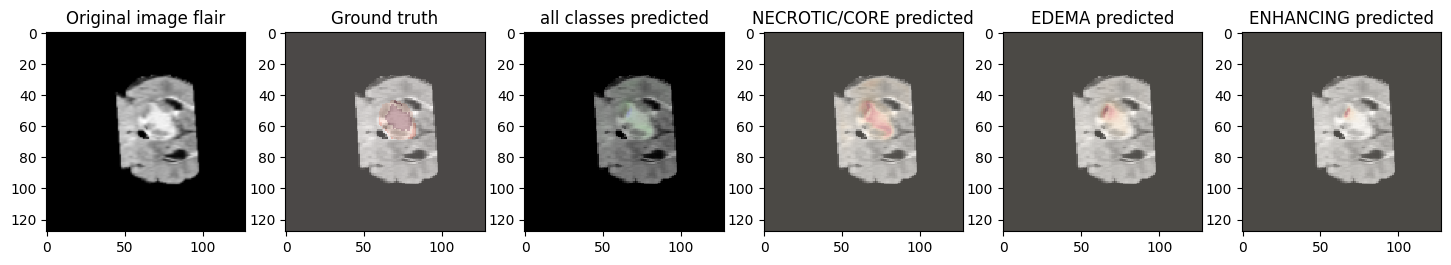

In [52]:
showPredictsById(case=test_ids[0][-3:])

In [53]:


def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)



In [54]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)
    plt.savefig(f'/content/drive/MyDrive/brats2/predicted_segmentations_{random_sample}.png')
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Patient number:  BraTS20_Training_357


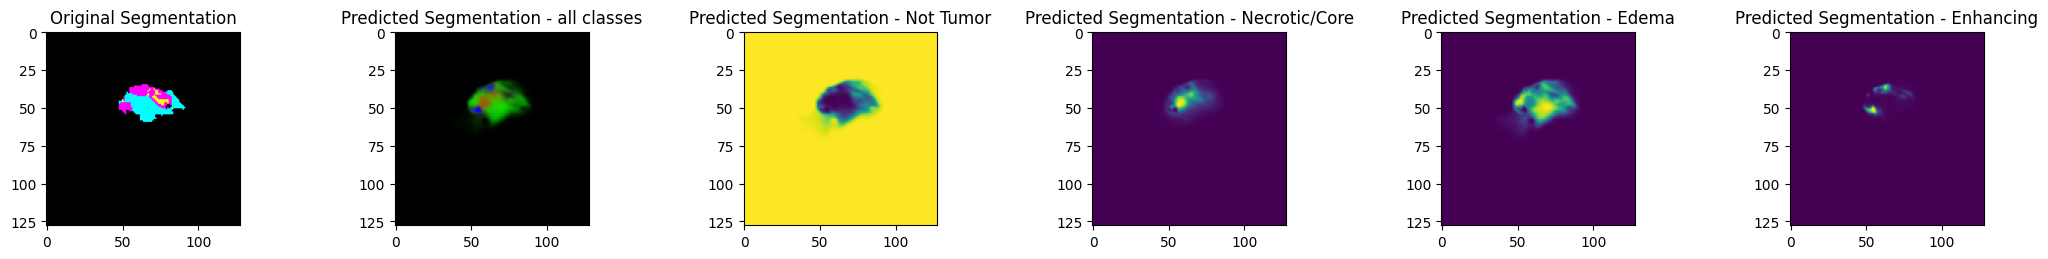

In [55]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Patient number:  BraTS20_Training_081


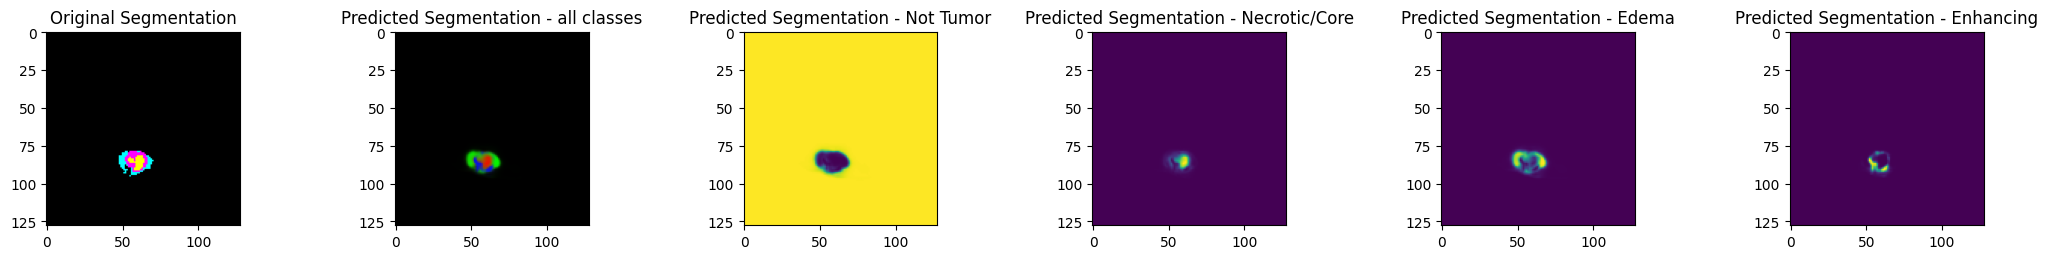

In [56]:
show_predicted_segmentations(test_ids, 65, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 640x480 with 0 Axes>

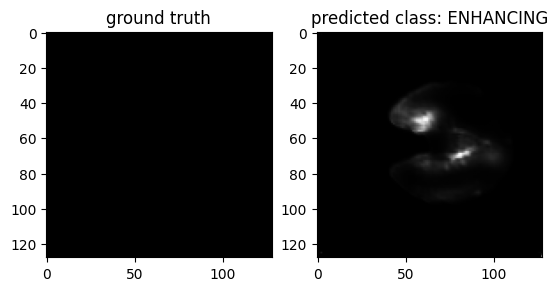

In [66]:
case = test_ids[10][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=20 # slice at
eval_class = 3 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 3 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.savefig(f'/content/drive/MyDrive/brats2/class_evaluation_{case}.png')
plt.show()

# 13. Evlauation

In [67]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef, precision, sensitivity, specificity,
        dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing
    ]
)
# Evaluate the model on the test dataset
test_results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)

# Define descriptions for each metric in the same order as returned by evaluate()
metric_descriptions = [
    "Loss",
    "Accuracy",
    "Mean IOU",
    "Dice Coefficient",
    "Precision",
    "Sensitivity",
    "Specificity",
    "Dice Coefficient (Necrotic)",
    "Dice Coefficient (Edema)",
    "Dice Coefficient (Enhancing)"
]

# Print the evaluation results with their descriptions
print("\nModel evaluation on the test set:")
print("==================================")
for metric, description in zip(test_results, metric_descriptions):
    print(f"{description}: {metric:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.9930 - dice_coef: 0.6099 - dice_coef_edema: 0.6985 - dice_coef_enhancing: 0.6753 - dice_coef_necrotic: 0.5324 - loss: 0.0199 - mean_io_u_2: 0.7450 - precision: 0.9944 - sensitivity: 0.9919 - specificity: 0.9981

Model evaluation on the test set:
Loss: 0.0231
Accuracy: 0.9921
Mean IOU: 0.7466
Dice Coefficient: 0.5898
Precision: 0.9937
Sensitivity: 0.9908
Specificity: 0.9979
Dice Coefficient (Necrotic): 0.5290
Dice Coefficient (Edema): 0.6681
Dice Coefficient (Enhancing): 0.5989


# II Classification
implementation of an SVM-based classifier that uses features extracted from the segmented tumor regions. In our hybrid approach, we first segment the tumor using our U‑Net model and then extract relevant features (such as the tumor area and mean intensity) from the segmented region. These features are used to train a Support Vector Machine (SVM) classifier that can distinguish between tumor subtypes (for example, high-grade vs. low-grade gliomas).

The steps are as follows:

1. **Feature Extraction:**
  For each patient, we select a representative slice (or combine features from several slices) from the FLAIR image and its corresponding segmentation mask. Using skimage.measure.regionprops, we extract features such as the area of the tumor region and the mean intensity inside the tumor region.

2. **SVM Training:**
  We split the extracted features and their corresponding tumor type labels into training and testing sets. Then, we use scikit-learn’s SVC to train an SVM classifier.

3. **Evaluation:**
  Finally, we evaluate the classifier using standard metrics like accuracy and produce a classification report.

Balanced patient IDs: ['260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '224', '094', '033', '043', '204', '013', '189', '027', '001', '078', '360', '006', '025', '339', '055', '359', '090', '123', '238', '161', '156', '038', '143', '206', '049', '230', '067', '129', '349', '149', '367', '356', '048', '243', '093', '249', '191', '165', '147', '162', '045', '119', '223', '183', '018', '215', '105', '072', '213', '171', '099', '034', '229', '031', '117', '024', '159', '118', '170', '115', '112', '040', '246', '017

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Feature matrix shape: (152, 8138)
Label vector shape: (152,)
Unique classes in dataset: [0 1]
After SMOTE, training data distribution: {0: 61, 1: 61}
Optimized threshold for HGG: 0.2795204771615954

Classification Report:
               precision    recall  f1-score   support

         LGG       1.00      0.31      0.48        16
         HGG       0.58      1.00      0.73        15

    accuracy                           0.65        31
   macro avg       0.79      0.66      0.60        31
weighted avg       0.80      0.65      0.60        31



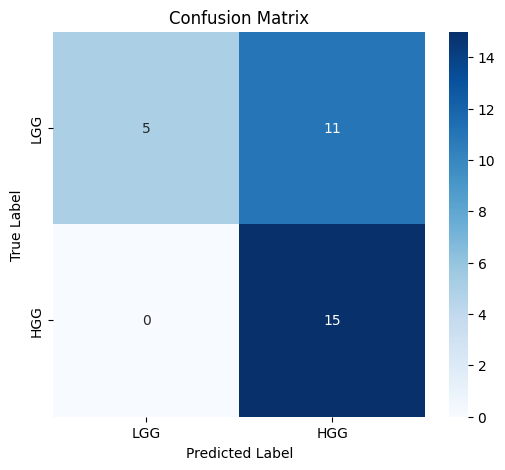

SVM model and artifacts saved.


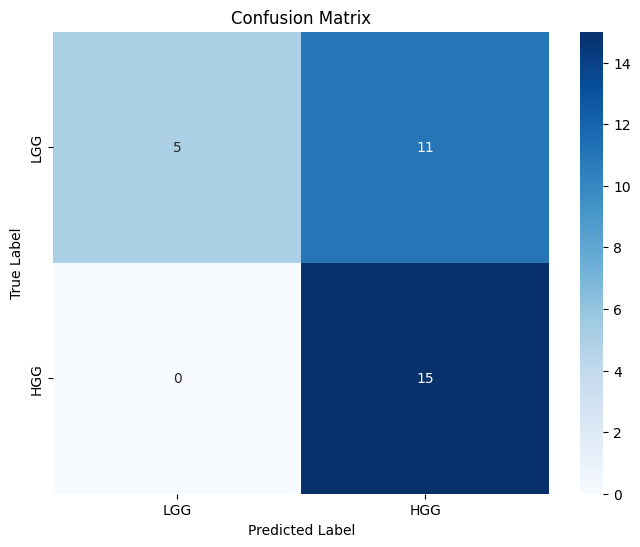

<Figure size 800x600 with 0 Axes>

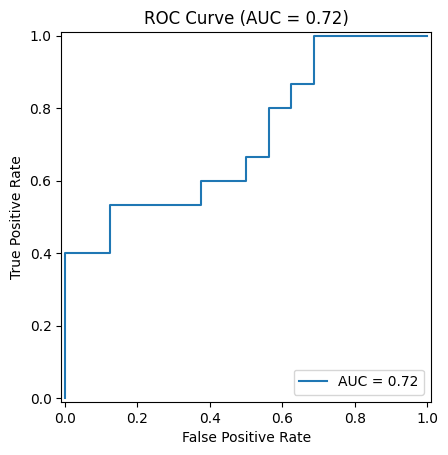

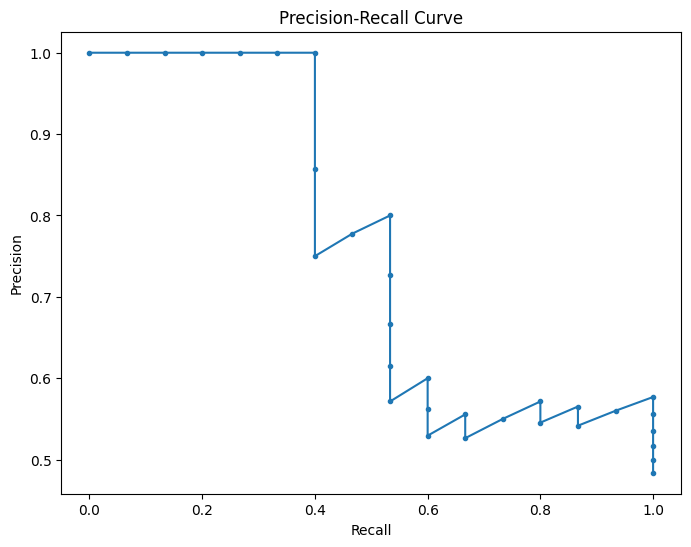


Final Model Performance:
Test Accuracy: 0.65
Test F1 Score: 0.73
ROC AUC: 0.72


In [68]:
import os
import numpy as np
import cv2
import nibabel as nib
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report,
                             precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Global configurations
IMG_SIZE = 128
VOLUME_START_AT = 22
SAVE_DIR = "/content/drive/MyDrive/brats2/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load metadata mapping file
mapping_csv_path = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv'
mapping_df = pd.read_csv(mapping_csv_path)

def get_patient_label(patient_id):
    """Get binary label (0=LGG, 1=HGG) for a patient ID."""
    pid_str = f'BraTS20_Training_{patient_id}'
    match = mapping_df[mapping_df['BraTS_2020_subject_ID'] == pid_str]
    if match.empty:
        raise ValueError(f"Patient {patient_id} not found in mapping")
    return 0 if match.iloc[0]['Grade'].upper() == "LGG" else 1

def extract_radiomics(image, seg_mask):
    """Extract comprehensive tumor features from an MRI slice."""
    # Basic tumor properties
    labeled_mask = label(seg_mask)
    regions = regionprops(labeled_mask, intensity_image=image)
    if not regions:
        base_feats = [0] * 6
    else:
        main_tumor = max(regions, key=lambda r: r.area)
        base_feats = [
            main_tumor.area,
            main_tumor.mean_intensity,
            main_tumor.eccentricity,
            main_tumor.solidity,
            main_tumor.extent,
            main_tumor.major_axis_length
        ]

    # Texture analysis using GLCM
    image_8bit = (image / (image.max() + 1e-9) * 255).astype(np.uint8)
    glcm = graycomatrix(image_8bit, distances=[2], angles=[0], symmetric=True, normed=True)
    texture_feats = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0]
    ]

    # Tumor core characteristics
    core_mask = np.isin(seg_mask, [1, 2, 4]).astype(int)
    core_feats = [0, 0]
    if core_mask.sum() > 0:
        core_props = regionprops(core_mask, intensity_image=image)[0]
        core_feats = [core_props.area, core_props.mean_intensity]

    return base_feats + texture_feats + core_feats

def letterbox_resize(image, target_size=IMG_SIZE):
    """
    Resize image while preserving aspect ratio and pad to target size.
    """
    h, w = image.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded

def preprocess_patient_slice(patient_id, base_dir="/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData", img_size=IMG_SIZE, vol_start=VOLUME_START_AT):
    """
    Loads and preprocesses a representative slice from a patient's FLAIR and segmentation volumes.
    Uses letterbox resizing to preserve the full image.
    """
    if patient_id.startswith("BraTS20_Training_"):
        folder_name = patient_id
    else:
        folder_name = f"BraTS20_Training_{patient_id}"

    patient_path = os.path.join(base_dir, folder_name)
    flair_path = os.path.join(patient_path, f"{folder_name}_flair.nii")
    seg_path   = os.path.join(patient_path, f"{folder_name}_seg.nii")

    flair_volume = nib.load(flair_path).get_fdata()
    seg_volume   = nib.load(seg_path).get_fdata()

    slice_idx = flair_volume.shape[2] // 2

    flair_slice = letterbox_resize(flair_volume[:, :, slice_idx], target_size=img_size)
    seg_slice   = letterbox_resize(seg_volume[:, :, slice_idx], target_size=img_size)

    # Normalize the FLAIR slice to [0, 1]
    flair_slice_norm = (flair_slice - flair_slice.min()) / (flair_slice.max() - flair_slice.min() + 1e-8)

    return flair_slice_norm, seg_slice

def extract_hog_features(flair_slice, visualize=False):
    """
    Extract HOG features from a FLAIR slice.
    """
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    hog_result = hog(flair_slice,
                     orientations=orientations,
                     pixels_per_cell=pixels_per_cell,
                     cells_per_block=cells_per_block,
                     block_norm='L2-Hys',
                     visualize=visualize,
                     transform_sqrt=True)
    if visualize:
        features, hog_image = hog_result
        return features, hog_image
    else:
        return hog_result

def extract_lbp_features(flair_slice):
    """
    Extract LBP features from a FLAIR slice and return a normalized histogram.
    """
    LBP_RADIUS = 3
    LBP_N_POINTS = 8 * LBP_RADIUS
    LBP_METHOD = "uniform"
    lbp = local_binary_pattern(flair_slice, LBP_N_POINTS, LBP_RADIUS, LBP_METHOD)
    n_bins = int(LBP_N_POINTS + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-8)
    return hist

def combine_features(basic_feats, hog_feats, lbp_feats):
    """
    Combine basic, HOG, and LBP features into one feature vector.
    """
    return np.concatenate([np.array(basic_feats), hog_feats, lbp_feats])

def build_feature_dataset(patient_ids, mapping_df):
    """
    Constructs the feature matrix and label vector by processing each patient.
    """
    features_list = []
    labels_list = []

    for pid in patient_ids:
        try:
            flair_slice, seg_slice = preprocess_patient_slice(pid)
        except Exception as e:
            print(f"Error processing patient {pid}: {e}")
            continue

        basic_feats = extract_radiomics(flair_slice, (seg_slice > 0).astype(np.uint8))
        hog_feats = extract_hog_features(flair_slice)
        lbp_feats = extract_lbp_features(flair_slice)
        combined_feats = combine_features(basic_feats, hog_feats, lbp_feats)
        features_list.append(combined_feats)
        label_val = get_patient_label(pid)
        labels_list.append(label_val)

    X = np.array(features_list)
    y = np.array(labels_list)
    return X, y

# For balanced patient selection, build a balanced list of IDs.
# We'll load all patient IDs from the CSV and balance them.
mapping_df['BraTS_2020_subject_ID'] = mapping_df['BraTS_2020_subject_ID'].astype(str).str.strip()
lgg_df = mapping_df[mapping_df['Grade'].str.upper() == 'LGG']
hgg_df = mapping_df[mapping_df['Grade'].str.upper() == 'HGG']
lgg_ids = [pid.split("_")[-1] for pid in lgg_df['BraTS_2020_subject_ID'].tolist()]
hgg_ids = [pid.split("_")[-1] for pid in hgg_df['BraTS_2020_subject_ID'].tolist()]

num_lgg = len(lgg_ids)
balanced_hgg_ids = hgg_ids if len(hgg_ids) <= num_lgg else np.random.choice(hgg_ids, num_lgg, replace=False).tolist()
classification_patient_ids = lgg_ids + balanced_hgg_ids
print("Balanced patient IDs:", classification_patient_ids)
print("Total balanced patients:", len(classification_patient_ids))

# --- Build the dataset ---
X, y = build_feature_dataset(classification_patient_ids, mapping_df)
print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)
print("Unique classes in dataset:", np.unique(y))

# --- Split the dataset ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Handle Class Imbalance using SMOTE ---
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE, training data distribution:", dict(zip(*np.unique(y_train_res, return_counts=True))))

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# --- Train the SVM Classifier ---
class_counts = np.bincount(y)
if len(class_counts) == 2:
    class_ratio = class_counts[1] / class_counts[0]
    class_weights = {0: class_ratio, 1: 1.0}
else:
    class_weights = None

svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight=class_weights,
    probability=True,
    random_state=42
)
svm.fit(X_train_scaled, y_train_res)

# --- Threshold Optimization on HGG probability (class 1) ---
from sklearn.metrics import precision_recall_curve
y_probs = svm.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Optimized threshold for HGG:", best_threshold)

y_pred = (y_probs >= best_threshold).astype(int)
y_probs_full = svm.predict_proba(X_test_scaled)

# --- Evaluation ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['LGG', 'HGG'], zero_division=0))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LGG', 'HGG'], yticklabels=['LGG', 'HGG'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --- Save the SVM Model and Artifacts ---
model_artifacts = {
    'model': svm,
    'scaler': scaler,
    'threshold': best_threshold,
    'feature_names': [
        'area', 'mean_intensity', 'eccentricity', 'solidity',
        'extent', 'major_axis', 'contrast', 'correlation',
        'energy', 'homogeneity', 'core_area', 'core_intensity',
        # Plus the number of bins from LBP: for uniform LBP, it is (8*3+2)=26 usually.
        'lbp_hist'  # you can later expand this to include details if needed.
    ]
}
joblib.dump(model_artifacts, os.path.join(SAVE_DIR, 'brain_tumor_classifier_v2.pkl'))
print("SVM model and artifacts saved.")

# --- Save Metrics and Plots ---
def save_metrics_report(y_true, y_pred, y_probs, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['LGG', 'HGG'], yticklabels=['LGG', 'HGG'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show()
    plt.close()

    # ROC Curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
    plt.show()
    plt.close()

    # Precision-Recall Curve
    from sklearn.metrics import precision_recall_curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs[:, 1])
    plt.figure(figsize=(8,6))
    plt.plot(recall_vals, precision_vals, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'))
    plt.show()
    plt.close()

    # Metrics summary
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc,
        'confusion_matrix': cm.tolist()
    }

    with open(os.path.join(save_dir, 'metrics_report.txt'), 'w') as f:
        f.write("Classification Report:\n")
        f.write(classification_report(y_true, y_pred, target_names=['LGG', 'HGG'], zero_division=0))
        f.write("\n\nMetrics Summary:\n")
        for k, v in metrics.items():
            if k != 'confusion_matrix':
                f.write(f"{k}: {v:.4f}\n")
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(cm, separator=', '))

    return metrics

metrics = save_metrics_report(y_test, y_pred, y_probs_full, SAVE_DIR)

print("\nFinal Model Performance:")
print(f"Test Accuracy: {metrics['accuracy']:.2f}")
print(f"Test F1 Score: {metrics['f1']:.2f}")
print(f"ROC AUC: {metrics['roc_auc']:.2f}")


In [71]:
import os
import numpy as np
import cv2
import nibabel as nib
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib

# Global configurations
IMG_SIZE = 128
SAVE_DIR = "/content/drive/MyDrive/brats2"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load metadata
mapping_df = pd.read_csv('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

def get_patient_label(patient_id):
    """Get binary label (0=LGG, 1=HGG) for a patient ID"""
    pid_str = f'BraTS20_Training_{patient_id}'
    match = mapping_df[mapping_df['BraTS_2020_subject_ID'] == pid_str]
    if match.empty:
        raise ValueError(f"Patient {patient_id} not found in mapping")
    return 0 if match.iloc[0]['Grade'].upper() == "LGG" else 1

def extract_radiomics(image, seg_mask):
    """Extract comprehensive tumor features from MRI slice"""
    # Basic tumor properties
    labeled_mask = label(seg_mask)
    regions = regionprops(labeled_mask, intensity_image=image)

    if not regions:
        base_feats = [0] * 6
    else:
        main_tumor = max(regions, key=lambda r: r.area)
        base_feats = [
            main_tumor.area,
            main_tumor.mean_intensity,
            main_tumor.eccentricity,
            main_tumor.solidity,
            main_tumor.extent,
            main_tumor.major_axis_length
        ]

    # Texture analysis
    image_8bit = (image / (image.max() + 1e-9) * 255).astype(np.uint8)
    glcm = graycomatrix(image_8bit, distances=[2], angles=[0], symmetric=True, normed=True)
    texture_feats = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0]
    ]

    # Tumor core characteristics
    core_mask = np.isin(seg_mask, [1, 2, 4]).astype(int)
    core_feats = [0, 0]
    if core_mask.sum() > 0:
        core_props = regionprops(core_mask, intensity_image=image)[0]
        core_feats = [core_props.area, core_props.mean_intensity]

    return base_feats + texture_feats + core_feats

def build_dataset(patient_ids):
    """Construct feature matrix and labels from patient data"""
    features, labels = [], []
    base_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

    for pid in patient_ids:
        try:
            # Load imaging data
            pid_dir = os.path.join(base_path, f"BraTS20_Training_{pid}")
            flair = nib.load(os.path.join(pid_dir, f"BraTS20_Training_{pid}_flair.nii")).get_fdata()
            seg = nib.load(os.path.join(pid_dir, f"BraTS20_Training_{pid}_seg.nii")).get_fdata()

            # Process middle slice
            mid_slice = flair.shape[2] // 2
            flair_slice = cv2.resize(flair[:, :, mid_slice], (IMG_SIZE, IMG_SIZE))
            seg_slice = cv2.resize(seg[:, :, mid_slice], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            # Extract features
            tumor_mask = (seg_slice > 0).astype(np.uint8)
            features.append(extract_radiomics(flair_slice, tumor_mask))
            labels.append(get_patient_label(pid))
        except Exception as e:
            print(f"Error processing {pid}: {str(e)}")

    return np.array(features), np.array(labels)

def save_metrics_report(y_true, y_pred, y_probs, save_dir):
    """Generate and save comprehensive evaluation visuals"""
    os.makedirs(save_dir, exist_ok=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['LGG', 'HGG'],
                yticklabels=['LGG', 'HGG'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
    plt.close()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'))
    plt.close()

    # Metrics summary
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc,
        'confusion_matrix': cm.tolist()
    }

    with open(os.path.join(save_dir, 'metrics_report.txt'), 'w') as f:
        f.write("Classification Report:\n")
        f.write(classification_report(y_true, y_pred, target_names=['LGG', 'HGG']))
        f.write("\n\nMetrics Summary:\n")
        for k, v in metrics.items():
            if k != 'confusion_matrix':
                f.write(f"{k}: {v:.4f}\n")
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(cm, separator=', '))

    return metrics

# Main execution
if __name__ == "__main__":
    # Data preparation
    patient_ids = [pid.split("_")[-1] for pid in mapping_df['BraTS_2020_subject_ID']]
    X, y = build_dataset(patient_ids)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    # Class weighting
    class_ratio = np.bincount(y)[1] / np.bincount(y)[0]
    class_weights = {0: class_ratio, 1: 1.0}

    # Model training
    svm = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight=class_weights,
        probability=True,
        random_state=42
    )
    svm.fit(X_train_scaled, y_res)

    # Threshold optimization
    y_probs = svm.predict_proba(X_test_scaled)[:, 0]
    precision, recall, thresholds = precision_recall_curve(y_test == 0, y_probs)
    best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-9))]

    # Generate predictions
    y_pred = (y_probs >= best_threshold).astype(int)
    y_probs_full = svm.predict_proba(X_test_scaled)

    # Save model and artifacts
    joblib.dump({
        'model': svm,
        'scaler': scaler,
        'threshold': best_threshold,
        'feature_names': [
            'area', 'mean_intensity', 'eccentricity', 'solidity',
            'extent', 'major_axis', 'contrast', 'correlation',
            'energy', 'homogeneity', 'core_area', 'core_intensity'
        ]
    }, os.path.join(SAVE_DIR, 'brain_tumor_classifier_v2.pkl'))

    # Generate all visual reports
    metrics = save_metrics_report(y_test, y_pred, y_probs_full, SAVE_DIR)

    # Final performance summary
    print("\nFinal Model Performance:")
    print(f"Test Accuracy: {metrics['accuracy']:.2f}")
    print(f"Test F1 Score: {metrics['f1']:.2f}")
    print(f"ROC AUC: {metrics['roc_auc']:.2f}")

# Example prediction code
def predict_tumor_class(model_path, features):
    """Make prediction with validation"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found")

    model_data = joblib.load(model_path)

    if len(features) != 12:
        raise ValueError("Requires exactly 12 features")

    scaled_features = model_data['scaler'].transform([features])
    lgg_prob = model_data['model'].predict_proba(scaled_features)[0][0]

    return {
        'class': 'LGG' if lgg_prob >= model_data['threshold'] else 'HGG',
        'confidence': max(lgg_prob, 1 - lgg_prob),
        'features_used': model_data['feature_names']
    }

# Example usage
if os.path.exists(os.path.join(SAVE_DIR, 'brain_tumor_classifier_v1.pkl')):
    sample_features = [
        2500, 85.3, 0.7, 0.9, 0.8, 45.0,
        0.2, 0.95, 0.85, 0.9, 1200, 90.0
    ]

    prediction = predict_tumor_class(
        os.path.join(SAVE_DIR, 'brain_tumor_classifier_v1.pkl'),
        sample_features
    )
    print("\nExample Prediction:")
    print(f"Class: {prediction['class']}")
    print(f"Confidence: {prediction['confidence']:.2%}")
else:
    print("Train the model first to generate predictions")


Final Model Performance:
Test Accuracy: 0.30
Test F1 Score: 0.40
ROC AUC: 0.66
Train the model first to generate predictions


<Figure size 800x600 with 0 Axes>

In [72]:
# Add this after the main training code but before the example prediction

def test_patient_prediction(model_path, patient_ids):
    """Test the model on specific patient cases"""
    if not os.path.exists(model_path):
        raise FileNotFoundError("Model file not found - train first")

    # Load model components
    model_data = joblib.load(model_path)
    scaler = model_data['scaler']
    model = model_data['model']
    threshold = model_data['threshold']

    # Process test patients
    for pid in patient_ids:
        try:
            # Extract features for this patient
            features, true_label = build_dataset([pid])

            # Skip patients that were in training data
            if pid in [p.split("_")[-1] for p in mapping_df['BraTS_2020_subject_ID']]:
                scaled_features = scaler.transform(features)
                lgg_prob = model.predict_proba(scaled_features)[0][0]
                prediction = 'LGG' if lgg_prob >= threshold else 'HGG'

                print(f"\nPatient {pid} Test:")
                print(f"True Label: {'LGG' if true_label[0] == 0 else 'HGG'}")
                print(f"Predicted: {prediction}")
                print(f"LGG Probability: {lgg_prob:.2%}")
                print(f"Correct: {true_label[0] == (0 if prediction == 'LGG' else 1)}")
            else:
                print(f"Patient {pid} not in dataset")
        except Exception as e:
            print(f"Error testing {pid}: {str(e)}")

# Example test cases (use actual patient IDs from your dataset)
test_patients = ['294', '300', '350','355','354']  # Replace with real patient IDs from your test set

if os.path.exists(os.path.join(SAVE_DIR, 'brain_tumor_classifier_v1.pkl')):
    print("\nReal Patient Tests:")
    test_patient_prediction(
        os.path.join(SAVE_DIR, 'brain_tumor_classifier_v1.pkl'),
        test_patients
    )